## Project: Predicting Stock Prices using time series analysis
## Part 1: Time Series Components
## Milestone 1: Data Extraction
**Source:** https://www.manning.com/liveprojectseries/time-series-for-stock-price-prediction-ser?new=true&experiment=C


### 1. Setting up environment

#### 1.1 Importing packages & setting-up parameters

In [76]:
import requests # to download data from api
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot


# Time Series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf


#turning on plot display in JN
%matplotlib inline 
# Setting pandas display options
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 250
pd.options.display.float_format = '{:.4f}'.format

In [77]:
# Import parent directory (main project directory)
# for packages importing
import sys
import os
import pathlib

# Getting the parent directory name in which your script is running
parent = os.path.dirname(os.path.realpath('/'))

# adding the parent directory to
# the sys.path.
sys.path.append(parent)

# now we can import the module in the parent
# directory.

In [78]:
# Adding private parameters
# vantage_api_key
parametersPath = os.path.join(pathlib.Path(os.path.dirname(os.path.realpath(''))).parent.parent.parent, 'Private')
sys.path.append(parametersPath)

from parameters import parameters_private as privparam

#### 1.2 Declaring additional classes & functions

In [79]:
# Function to download data from Alpha Vantage and add date variables
def get_data_vantage(symbol, apikey, start_date = None, end_date = None):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&outputsize=full&symbol={symbol}&apikey={apikey}&datatype=csv'
    data = pd.read_csv(url)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    if start_date is not None and end_date is not None:
        data = data[(data['timestamp'] > start_date) & (data['timestamp'] <= end_date)]
        data["year"] = data["timestamp"].dt.year
        data["quarter"] = data["timestamp"].dt.quarter
        data["month"] = data["timestamp"].dt.month
        data["weekday"] = data["timestamp"].dt.weekday
        data["day"] = data["timestamp"].dt.dayofyear
        data.sort_values(by='timestamp', inplace=True)

    return data

In [80]:
# https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c
# https://github.com/statsmodels/statsmodels/issues/6851#event-3511269194

class TSPlots():
    def __init__(self, series_in, title = None, alpha = 0.05, nlags = 30):
        self.series_in = series_in
        self.alpha = alpha
        self.nlags = nlags
        self.title = title
        self._acf()
        self._pacf()
        return

    def _acf(self):
        acfD, confintD, qstatD, pvaluesD = acf(self.series_in, qstat = True, alpha = self.alpha, nlags = self.nlags)
        print('Lags with statistically significant autocorrelation')
        self.acfd = acfD
        self.aconfintD = confintD
        self._count(statistic = self.acfd, ci = self.aconfintD)    
        plot_acf(self.series_in, lags = self.nlags)
        plt.title(f'{self.title} Autocorrelation')
        plt.show()
        return

    def _pacf(self):
        pacfD, pconfintD = pacf(self.series_in, alpha=0.05, nlags=self.nlags)
        print('Lags with statistically significant partial autocorrelation')
        self.pacfd = pacfD
        self.paconfintD = pconfintD    
        self._count(statistic = self.pacfd, ci = self.paconfintD)
        plot_pacf(self.series_in, lags = self.nlags)
        plt.title(f'{self.title} Partial Autocorrelation')
        plt.show()
        return

    def _count(self, statistic, ci):       
        count = 0 
        temp_list = []
        for i in range(1,len(statistic)):
            if abs(statistic[i]) > ci[i][1]-statistic[i]:
                count += 1
                temp_list.append(i)
        if count > 0:
            print(temp_list)
            print('Time series is non random - consider ARMA(p,q) adjustments.')
        return

#### 1.3 Data import and inspection

In [81]:
# Downloading Verizon and AT&T full historic data
# Limiting to required dates - 01/01/2019 to 06/01/2021 
verizon_data = get_data_vantage(symbol = 'VZ', apikey = privparam.vantageApiKey, start_date = '2018-12-31', end_date = '2021-06-01')
att_data = get_data_vantage(symbol = 'T', apikey = privparam.vantageApiKey, start_date = '2018-12-31', end_date = '2021-06-01')

In [82]:
# Inspecting data
print(verizon_data.head())
print(verizon_data.info())
print(att_data.head())
print(att_data.info())

      timestamp    open    high     low   close    volume  year  quarter  \
1163 2019-01-02 56.1600 56.1600 55.2800 56.0200  13969691  2019        1   
1162 2019-01-03 56.3000 56.9900 56.0600 56.2200  19245411  2019        1   
1161 2019-01-04 56.4900 56.8900 55.9500 56.3600  17035848  2019        1   
1160 2019-01-07 56.7600 57.2600 56.5500 56.7200  16348982  2019        1   
1159 2019-01-08 57.2700 58.6900 57.0500 58.3800  21425008  2019        1   

      month  weekday  day  
1163      1        2    2  
1162      1        3    3  
1161      1        4    4  
1160      1        0    7  
1159      1        1    8  
<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 1163 to 556
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  608 non-null    datetime64[ns]
 1   open       608 non-null    float64       
 2   high       608 non-null    float64       
 3   low        608 non-null    float

### 2. Exploratory Data Analysis

#### 2.1 Verizon Communications

Verizon Communications is a US telecom company providing internet, mobile and tv services.  
https://en.wikipedia.org/wiki/Verizon_Communications

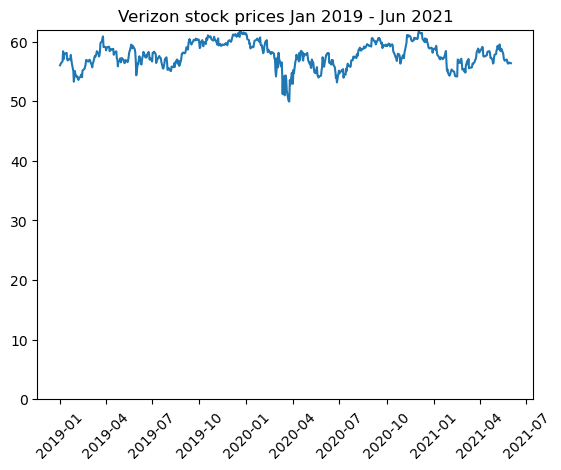

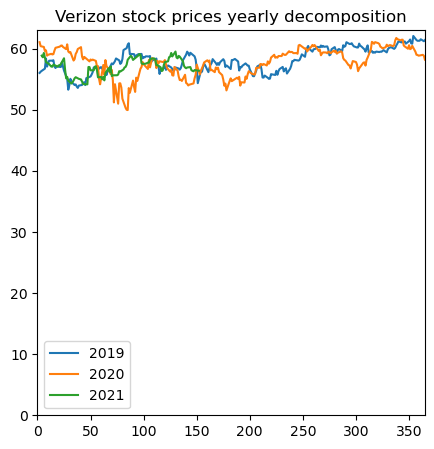

In [83]:
plt.plot(verizon_data['timestamp'], verizon_data['close'], label='Verizon')
plt.xticks(rotation=45)
plt.ylim((0, 62))
plt.title('Verizon stock prices Jan 2019 - Jun 2021')
plt.show()
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(verizon_data[verizon_data['year'] == 2019]['day'], verizon_data[verizon_data['year'] == 2019]['close'], label='2019')
ax.plot(verizon_data[verizon_data['year'] == 2020]['day'], verizon_data[verizon_data['year'] == 2020]['close'], label='2020')
ax.plot(verizon_data[verizon_data['year'] == 2021]['day'], verizon_data[verizon_data['year'] == 2021]['close'], label='2021')
plt.xlim((0, 365))
plt.ylim((0, 63))
plt.title('Verizon stock prices yearly decomposition')
plt.legend()
plt.show()

Looking at the yearly decomposition of stock valuation it seems that we might have a seasonal component - with valuation slightly higher toward end of the year (maybe because of more time in front of tv or higher internet usage during winter months?). No clearly visible trend.

In [84]:
# How many trading days are in a year?
print(verizon_data['year'].value_counts())
print(att_data['year'].value_counts())
# 2021 has half trading days (data till June)

year
2020    253
2019    252
2021    103
Name: count, dtype: int64
year
2020    253
2019    252
2021    103
Name: count, dtype: int64


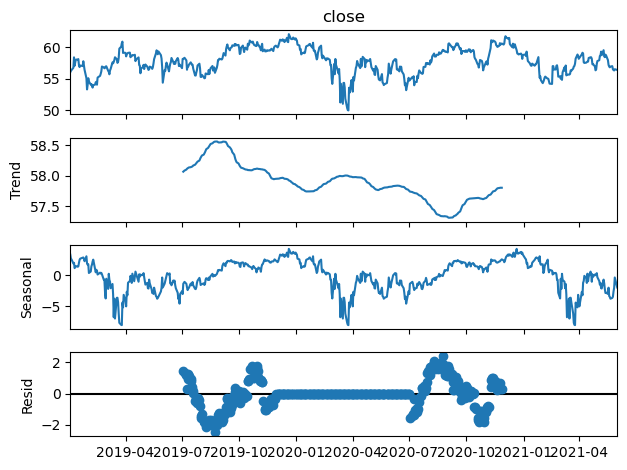

In [85]:
verizon_series = verizon_data.set_index('timestamp')['close'].squeeze()
result = seasonal_decompose(verizon_series, period = 252, model = 'additive') # 252 - number of trading days in a year
result.plot()
pyplot.show()

Based on seasonal seasonal decomposition function:
1) There is a slight downward trend present with mild recovery at the end of trend data. More trend data would be availbe if we analysed a broader timeframe.
2) There is a seasonal component driving stock prices down each April
3) Middle period 2019-12 to 2020-07 seems well explained by seasonal and trend componens (residuals close to 0), while outside those period we have varying remainder

In [86]:
TSPlots(series_in = verizon_series, title = 'Verizon')

Lags with statistically significant autocorrelation


NameError: name 'acfd' is not defined

#### 2.1 AT&T Corporation

AT&T Corporation is a US telecom company providing internet, mobile and tv services.  
https://en.wikipedia.org/wiki/AT%26T_Corporation 

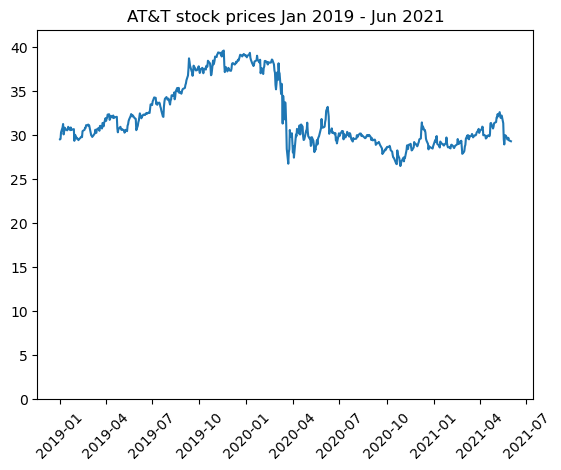

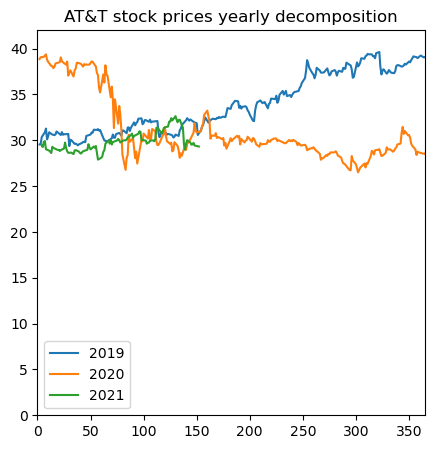

In [ ]:
plt.plot(att_data['timestamp'], att_data['close'], label='AT&T')
plt.xticks(rotation=45)
plt.ylim((0, 42))
plt.title('AT&T stock prices Jan 2019 - Jun 2021')
plt.show()
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(att_data[att_data['year'] == 2019]['day'], att_data[att_data['year'] == 2019]['close'], label='2019')
ax.plot(att_data[att_data['year'] == 2020]['day'], att_data[att_data['year'] == 2020]['close'], label='2020')
ax.plot(att_data[att_data['year'] == 2021]['day'], att_data[att_data['year'] == 2021]['close'], label='2021')
plt.xlim((0, 365))
plt.ylim((0, 42))
plt.title('AT&T stock prices yearly decomposition')
plt.legend()
plt.show()

Looking at the yearly decomposition of stock valuation I don't see a clear seasonal component. There was a upward trend present until abrupt decrease in valuation around COVID (March 2020). Afterwards I don't asee a clear trend.

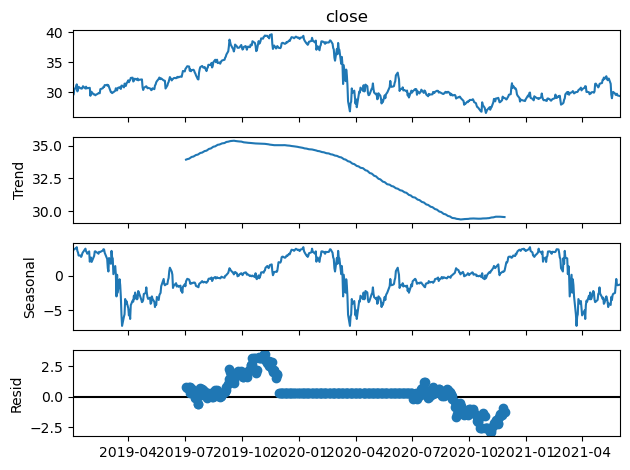

In [ ]:
att_series = att_data.set_index('timestamp')['close'].squeeze()
result = seasonal_decompose(att_series, model = 'additive', period = 252) # 252 - number of trading days in a year
result.plot()
pyplot.show()


Based on seasonal seasonal decomposition function:
1) There is a clear downward trend. More trend data would be availbe if we analysed a broader timeframe.
2) There is a seasonal component driving stock prices down each April (maybe this is common for telecommunications sector? Would require broarder knowledge on the subject)
3) Middle period 2019-12 to 2020-07 seems well explained by seasonal and trend componens (residuals close to 0), previous to that remainders are over 0 (seasonal and trend componens suggest lower stock valuation than observed) vs opposite scenario after 2020-07 when remainders are negative

Lags with statistically significant autocorrelation
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Time series is non random - consider ARMA(p,q) adjustments.


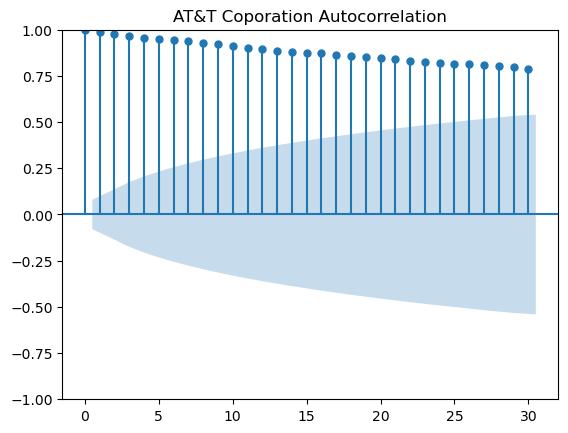

Lags with statistically significant partial autocorrelation
[1, 2, 5, 7, 8, 10, 14, 28, 30]
Time series is non random - consider ARMA(p,q) adjustments.


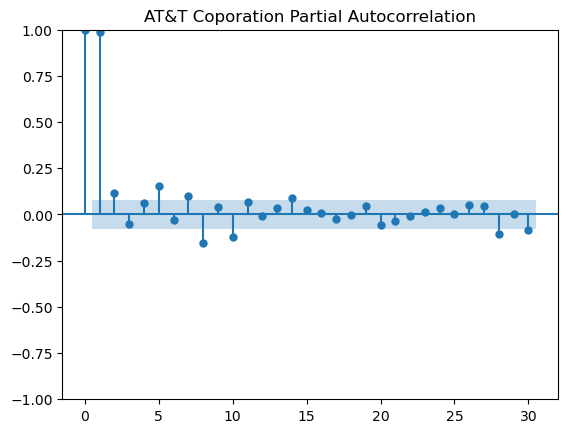

In [ ]:
TSPlots(series_in = att_series, title = 'AT&T Coporation')